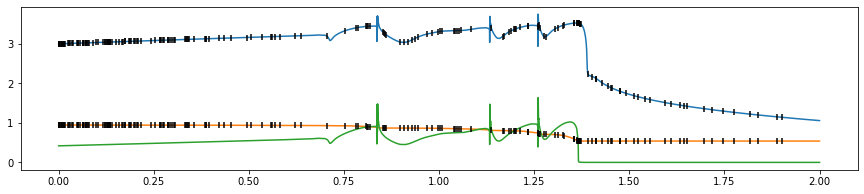

In [2]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from operator import itemgetter
from more_itertools import unique_everseen


###################
### DEFINITIONS ###
###################


radeg = np.pi/180

def add_tr(sim, pars):
    sem = pars[0]
    ecc = pars[1]
    icl = pars[2]*radeg
    Ome = pars[3]
    pme = pars[4]
    lam = pars[5] 
    has = 'tr'
    sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, pomega=pme, l=lam, hash=has)

def add_jp(sim, pars):
    sem = pars[0]
    ecc = pars[1]
    icl = pars[2]*radeg
    pme = pars[3]
    lam = pars[4]
    has = 'jupiter'
    sim.add(m=9.543e-4, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, pomega=pme, l=lam, hash=has)
    
def rho_star(m,r):
    R = r*1.496e13
    M = m*1.989e33
    vol = 4/3 * np.pi * R**3
    rho = M / vol
    return rho

def roche(msol,rsol,density):
    rhosol = rho_star(msol,rsol)
    argume = 2*rhosol/density
    return rsol * np.power(argume, 1/3)

###############
### IMPORTS ###
###############


target = '1kB'

params = np.load('{0}_redopars.npy'.format(target))
juppar = np.load('{0}_redojups.npy'.format(target))
times_ = (np.load('{0}_redotime.npy'.format(target))*20)

file = np.loadtxt('star_track.txt')
sol_t = file[807:,0]
sol_m = file[807:,1]
sol_l = file[807:,6]
sol_r = np.power(10,file[807:,13])*.00465047
log_l = InterpolatedUnivariateSpline((sol_t-sol_t[0]), sol_l,k=1)
m_sol = InterpolatedUnivariateSpline((sol_t-sol_t[0]), sol_m,k=1)
r_sol = InterpolatedUnivariateSpline((sol_t-sol_t[0]), sol_r,k=1)

x = np.linspace(0,2e6,5000)
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(x/1e6,log_l(x),zorder=0)
ax.plot(x/1e6,m_sol(x),zorder=0)
ax.plot(x/1e6,r_sol(x),zorder=0)
ax.scatter(times_/1e6,log_l(times_),c='k',marker='|')
ax.scatter(times_/1e6,m_sol(times_),c='k',marker='|')
fig.show()

In [3]:
t_tot = 30000
Nout = 60000
times = np.linspace(0,t_tot,Nout)

num_tr = len(times_)

mass = np.zeros((num_tr, Nout)); lsol = np.zeros((num_tr, Nout)); 
x_sol = np.zeros((num_tr, Nout)); y_sol = np.zeros((num_tr, Nout)); z_sol = np.zeros((num_tr, Nout))

x_jup = np.zeros((num_tr, Nout)); y_jup = np.zeros((num_tr, Nout)); z_jup = np.zeros((num_tr, Nout))
a_jup = np.zeros((num_tr, Nout)); e_jup = np.zeros((num_tr, Nout)); i_jup = np.zeros((num_tr, Nout))
pmjup = np.zeros((num_tr, Nout)); lmjup = np.zeros((num_tr, Nout))

a_vals = np.zeros((num_tr, Nout)); e_vals = np.zeros((num_tr, Nout)); i_vals = np.zeros((num_tr, Nout))
omvals = np.zeros((num_tr, Nout)); pmvals = np.zeros((num_tr, Nout)); lmvals = np.zeros((num_tr, Nout))
x_vals = np.zeros((num_tr, Nout)); y_vals = np.zeros((num_tr, Nout)); z_vals = np.zeros((num_tr, Nout))
print(num_tr)

188


In [4]:
%%time

for asteroid in range(num_tr):
    T0 = times_[asteroid] + sol_t[0]
    M0 = m_sol(T0)
    
    sim = rebound.Simulation()

    sim.add(m=M0,x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='Sun')
    add_tr(sim, params[:,asteroid])
    add_jp(sim, juppar[:,asteroid])

    sim.t = 0
    sim.integrator = 'ias15'
    sim.move_to_com()

    ps = sim.particles

    
########################################


    x_sol[asteroid,0] = ps['Sun'].x
    y_sol[asteroid,0] = ps['Sun'].y
    z_sol[asteroid,0] = ps['Sun'].z

    a_jup[asteroid,0] = ps['jupiter'].a
    e_jup[asteroid,0] = ps['jupiter'].e
    i_jup[asteroid,0] = ps['jupiter'].inc
    pmjup[asteroid,0] = ps['jupiter'].pomega
    lmjup[asteroid,0] = ps['jupiter'].l
    x_jup[asteroid,0] = ps['jupiter'].x
    y_jup[asteroid,0] = ps['jupiter'].y
    z_jup[asteroid,0] = ps['jupiter'].z
    
    a_vals[asteroid,0] = ps['tr'].a
    e_vals[asteroid,0] = ps['tr'].e
    i_vals[asteroid,0] = ps['tr'].inc
    lmvals[asteroid,0] = ps['tr'].l
    omvals[asteroid,0] = ps['tr'].Omega
    pmvals[asteroid,0] = ps['tr'].pomega
    x_vals[asteroid,0] = ps['tr'].x
    y_vals[asteroid,0] = ps['tr'].y
    z_vals[asteroid,0] = ps['tr'].z

    
###########################
###########################
###########################

    
    for i, time in enumerate(times):
        sim.integrate(time)

        ps['Sun'].m = m_sol(sim.t + T0)
        sim.move_to_com()

        lsol[asteroid,i] = log_l(sim.t + T0)    
        mass[asteroid,i] = ps['Sun'].m
        x_sol[asteroid,i] = ps['Sun'].x
        y_sol[asteroid,i] = ps['Sun'].y
        z_sol[asteroid,i] = ps['Sun'].z

        x_jup[asteroid,i] = ps['jupiter'].x
        y_jup[asteroid,i] = ps['jupiter'].y 
        z_jup[asteroid,i] = ps['jupiter'].z
        a_jup[asteroid,i] = ps['jupiter'].a
        e_jup[asteroid,i] = ps['jupiter'].e
        i_jup[asteroid,i] = ps['jupiter'].inc
        pmjup[asteroid,i] = ps['jupiter'].pomega
        lmjup[asteroid,i] = ps['jupiter'].l

        a_vals[asteroid,i] = ps['tr'].a
        e_vals[asteroid,i] = ps['tr'].e
        i_vals[asteroid,i] = ps['tr'].inc
        lmvals[asteroid,i] = ps['tr'].l
        omvals[asteroid,i] = ps['tr'].Omega
        pmvals[asteroid,i] = ps['tr'].pomega
        x_vals[asteroid,i] = ps['tr'].x
        y_vals[asteroid,i] = ps['tr'].y
        z_vals[asteroid,i] = ps['tr'].z
        
    sim.remove(hash='Sun')
    sim.remove(hash='jupiter')
    sim.remove(hash='tr')

/home/mdodici/anaconda3/lib/python3.7/site-packages/rebound/simulation.py:675: RuntimeWarning: Last particle removed.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 43min 48s, sys: 28.6 s, total: 44min 17s
Wall time: 44min 23s


In [5]:
dist_j = np.sqrt((x_vals - x_jup)**2 + (y_vals - y_jup)**2 + (z_vals - z_jup)**2)
dist_s = np.sqrt((x_vals - x_sol)**2 + (y_vals - y_sol)**2 + (z_vals - z_sol)**2)

In [9]:
def roch2(x,y,M1,M2,a):
    q = M2/M1
    x /= a
    y /= a
    s1 = np.sqrt(x**2 + y**2)
    s2 = np.sqrt((x-1)**2 + y**2)
    
    term1 = 2/(s1*(1+q))
    term2 = 2*q/(s2*(1+q))
    term3 = (x - q/(1+q))**2
    term4 = y**2
    return term1 + term2 + term3 + term4

def cart_to_pol(x,y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return r, phi

def pol_to_cart(r,phi):
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return x, y

def L45(msun,mjup):
    u2 = mjup/(msun+mjup)
    
    x_L4 = 0.5 - u2
    x_L5 = x_L4
    
    y_L4 = np.sqrt(3)/2
    y_L5 = -y_L4
    
    return np.array([x_L4,x_L5]), np.array([y_L4,y_L5])

def L45_nonnorm(xjup,yjup,xsun,ysun):
    phi_jup = np.arctan2(yjup,xjup)
    
    phi_L4 = phi_jup + np.pi/3
    phi_L5 = phi_jup - np.pi/3
    
    xsep = (xsun - xjup)
    ysep = (ysun - yjup)
    
    r_jupsol = np.sqrt(xsep**2 + ysep**2)
    
    x_L4 = r_jupsol*np.cos(phi_L4)
    x_L5 = r_jupsol*np.cos(phi_L5)
    y_L4 = r_jupsol*np.sin(phi_L4)
    y_L5 = r_jupsol*np.sin(phi_L5)
    
    return np.array([x_L4,x_L5]), np.array([y_L4,y_L5])

def hill(a,e,m,M):
    return a*(1-e)*np.power(m/(3*M),1/3)

def r_pol(r,psi,M1,M2,a):
    q = M2/M1
    z = np.zeros((len(psi),len(r)))
    for i, phi in enumerate(psi):
        x_ = r*np.cos(phi)
        y_ = r*np.sin(phi)
        x = x_/a
        y = y_/a
        s1 = np.sqrt(x**2 + y**2)
        s2 = np.sqrt((x-1)**2 + y**2)
    
        term1 = 2/(s1*(1+q))
        term2 = 2*q/(s2*(1+q))
        term3 = (x - q/(1+q))**2
        term4 = y**2
        z[i] = term1 + term2 + term3 + term4
    return z

r_vals, phvals = cart_to_pol(x_vals,y_vals)
r_jup, phjup = cart_to_pol(x_jup,y_jup)

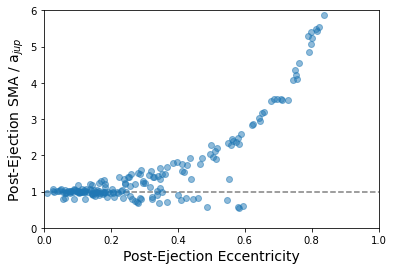

In [11]:
fig, ax = plt.subplots()
ax.scatter(e_vals.T[-1], a_vals.T[-1]/a_jup.T[-1],alpha=.5)
ax.set_ylim(0,6)
ax.set_xlim(0,1)
ax.set_ylabel(r'Post-Ejection SMA / a$_{jup}$',fontsize=14)
ax.set_xlabel(r'Post-Ejection Eccentricity',fontsize=14)
ax.plot(np.linspace(0,1),np.ones(50),'k',alpha=0.5,ls='--',zorder=0)
fig.show()

In [17]:
np.save('final_ae_b1.npy', np.array([a_vals.T[-1],a_jup.T[-1],e_vals.T[-1]]))

In [13]:
peri_vals = a_vals*(1 - e_vals)
apoa_vals = a_vals*(1 + e_vals)

x = np.linspace(0,2e6,500)
solar = r_sol(x)

time_ajups = zip(times_,a_jup[:,-1])
t_aj_sortd = sorted(time_ajups)
t_aj_uniq = unique_everseen(t_aj_sortd,key=itemgetter(0))
tesort, tjsort = zip(*t_aj_uniq)
ajup_smooth = InterpolatedUnivariateSpline(tesort,tjsort,k=1)
jup_sma = ajup_smooth(x)

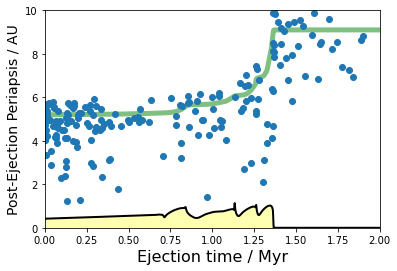

In [14]:
fig, ax = plt.subplots()
ax.scatter(times_/1e6,peri_vals[:,-1])
ax.plot(x/1e6,jup_sma,'g',alpha=0.5,lw=5,zorder=0)
ax.plot(x/1e6,solar,c='k',lw=2)
ax.fill_between(x/1e6,np.zeros_like(x),solar,facecolor='yellow',alpha=0.3)
ax.set_ylabel(r'Post-Ejection Periapsis / AU',fontsize=14)
ax.set_xlabel('Ejection time / Myr',fontsize=16)
ax.set_ylim(0,10)
ax.set_xlim(0,2)
fig.show()

In [16]:
np.save('Peri-Apo-B1.npy',np.array((times_,peri_vals[:,-1],apoa_vals[:,-1])))

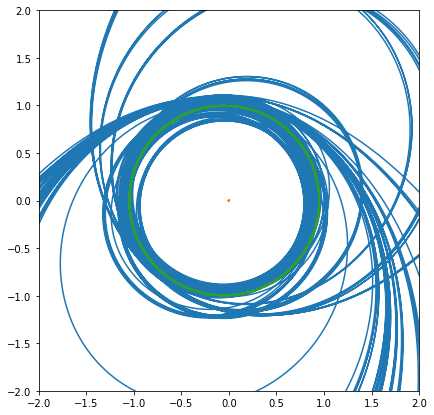

In [379]:
roche_s = []
crash_s = []
crash_j = []

rocstr = roche(m_sol(times_),r_sol(times_),3)
r_plnt = 4.779e-4
for i in range(num_tr):
    r_star = r_sol(times_[i])
    rochet = rocstr[i]
    step = 0
    while step < Nout:
        t_ = times[step] + times_[i]
        ds = dist_s[i,step]
        dj = dist_j[i,step]
        if dj < r_plnt:
            crash_j.append(i)
            break
        if ds < r_star:
            crash_s.append(i)
            break
        if ds < rochet:
            roche_s.append(i)
            break
            
        step += 1

rocdx = np.array(roche_s)
crsdx = np.array(crash_s)
crjdx = np.array(crash_j)

print('Number crashing into Jup: ', len(crjdx))
print('Number crashing into Sol: ', len(crsdx))
print('Number of roche crossers: ', len(rocdx))

In [ ]:
##############
##  Saving  ##
##############


i_vals/= radeg
i_jup /= radeg

troj_data = np.array((a_vals, e_vals, i_vals, omvals, pmvals, lmvals, x_vals, y_vals, z_vals))
plnt_data = np.array((a_jup, e_jup, i_jup, pmjup, lmjup, x_jup, y_jup, z_jup))
star_data = np.array((mass, lsol, x_sol, y_sol, z_sol))

np.save("{0}_redodata.npy".format(target), troj_data)
np.save("{0}_repldata.npy".format(target), plnt_data)
np.save("{0}_restdata.npy".format(target), star_data)
np.save("{0}_retimes.npy".format(target), times)